### Economic Regime Hedging Strategy

Task : Begin by defining economic regimes based on inflation or growth trends. Try to find the optimal hedge for the S&P 500 depending on which economic regime you are in. The hedges will be a mix of gold and US treasuries. 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [25]:
# Load data
file_path = 'Data_180724.xlsx'
excel_data = pd.ExcelFile(file_path)

macro_data = pd.read_excel(file_path, sheet_name='Macro')
prices_data = pd.read_excel(file_path, sheet_name='Prices')
yield_data = pd.read_excel(file_path, sheet_name='Yield')

# Merge the dataframes and sort by date
combined_data = pd.merge(macro_data, prices_data, on='Date')
combined_data = pd.merge(combined_data, yield_data, on='Date')

combined_data['Date'] = pd.to_datetime(combined_data['Date']) # easier for Python to handle

combined_data.sort_values('Date', inplace=True)

In [26]:
# Calculate returns
combined_data['S&P 500 Return'] = combined_data['S&P 500'].pct_change()
combined_data['Gold Return'] = combined_data['Gold'].pct_change()
combined_data['US 10YR Bonds Return'] = combined_data['US 10YR Bonds'].pct_change()

# Drop the first row since it contains null values
combined_data = combined_data.dropna()
combined_data

,Date,GDP YOY,CPI YOY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds,S&P 500 Return,Gold Return,US 10YR Bonds Return
1,1971-03-31,2.7,4.7,100.31,38.87,120.170,5.5320,0.088551,0.038194,-0.149185
3,1971-06-30,3.1,4.6,99.70,40.10,119.160,6.7020,-0.040885,0.027942,0.101940
5,1971-09-30,3.0,4.1,98.34,42.02,114.930,6.0020,-0.006968,-0.016616,-0.044572
11,1972-06-30,5.2,2.7,107.14,62.09,108.510,6.1520,-0.021821,0.136763,0.016523
24,1973-12-31,4.0,8.7,97.55,106.72,102.390,6.9020,0.016569,0.125501,0.031381
...,...,...,...,...,...,...,...,...,...,...
435,2022-03-31,3.6,8.5,4530.41,1937.44,98.312,2.3380,0.035773,0.014903,0.281096
437,2022-06-30,1.9,9.1,3785.38,1807.27,104.685,3.0129,-0.083920,-0.016371,0.059351
439,2022-09-30,1.7,8.2,3585.62,1660.61,112.117,3.8286,-0.093396,-0.029473,0.199211
444,2023-03-31,1.7,5.0,4109.31,1969.28,102.506,3.4676,0.035052,0.077923,-0.115408


Define economic regimes based on inflation (CPI) and growth (GDP). Consider changing thresholds for different results.

In [27]:
gdp_threshold = 2.0
cpi_threshold = 2.0

def classify_regime(row):
    if row['CPI YOY'] > cpi_threshold and row['GDP YOY'] > gdp_threshold:
        return 'High Inflation, High Growth'
    elif row['CPI YOY'] > cpi_threshold and row['GDP YOY'] <= gdp_threshold:
        return 'High Inflation, Low Growth'
    elif row['CPI YOY'] <= cpi_threshold and row['GDP YOY'] > gdp_threshold:
        return 'Low Inflation, High Growth'
    else:
        return 'Low Inflation, Low Growth'

combined_data['Economic Regime'] = combined_data.apply(classify_regime, axis=1)

combined_data.tail(10)

,Date,GDP YOY,CPI YOY,S&P 500,Gold,USD Index Spot Rate,US 10YR Bonds,S&P 500 Return,Gold Return,US 10YR Bonds Return,Economic Regime
424,2020-12-31,-1.1,1.4,3756.07,1898.36,89.937,0.9132,0.037121,0.068325,0.088568,"Low Inflation, Low Growth"
425,2021-03-31,1.6,2.6,3972.89,1707.71,93.232,1.7404,0.057725,-0.100429,0.905826,"High Inflation, Low Growth"
428,2021-06-30,11.9,5.4,4297.50,1770.11,92.436,1.4680,0.027822,-0.071720,-0.079220,"High Inflation, High Growth"
430,2021-09-30,4.7,5.4,4307.54,1756.95,94.230,1.4873,-0.047569,-0.031247,0.136384,"High Inflation, High Growth"
432,2021-12-31,5.4,7.0,4766.18,1829.20,95.670,1.5101,0.043613,0.030814,0.045558,"High Inflation, High Growth"
435,2022-03-31,3.6,8.5,4530.41,1937.44,98.312,2.3380,0.035773,0.014903,0.281096,"High Inflation, High Growth"
437,2022-06-30,1.9,9.1,3785.38,1807.27,104.685,3.0129,-0.083920,-0.016371,0.059351,"High Inflation, Low Growth"
439,2022-09-30,1.7,8.2,3585.62,1660.61,112.117,3.8286,-0.093396,-0.029473,0.199211,"High Inflation, Low Growth"
444,2023-03-31,1.7,5.0,4109.31,1969.28,102.506,3.4676,0.035052,0.077923,-0.115408,"High Inflation, Low Growth"
446,2023-06-30,2.4,3.0,4450.38,1919.35,102.912,3.8367,0.064728,-0.022102,0.053286,"High Inflation, High Growth"


Assume the usual portfolio metrics to evaluate performance: mean return and volatility

In [28]:
# Calculate performance metrics and re-arrange columns
performance_metrics = combined_data.groupby('Economic Regime').agg({
    'S&P 500 Return': ['mean', 'std'],
    'Gold Return': ['mean', 'std'],
    'US 10YR Bonds Return': ['mean', 'std']
}).reset_index()

performance_metrics.columns = ['Economic Regime', 
                               'S&P 500 Mean Return', 'S&P 500 Volatility',
                               'Gold Mean Return', 'Gold Volatility', 
                               'US 10YR Bonds Mean Return', 'US 10YR Bonds Volatility']

In [29]:
performance_metrics

,Economic Regime,S&P 500 Mean Return,S&P 500 Volatility,Gold Mean Return,Gold Volatility,US 10YR Bonds Mean Return,US 10YR Bonds Volatility
0,"High Inflation, High Growth",0.018015,0.045257,0.010331,0.050693,0.005583,0.062082
1,"High Inflation, Low Growth",-0.015950,0.066059,-0.027754,0.103424,0.041560,0.187261
2,"Low Inflation, High Growth",0.015161,0.059416,0.011358,0.056028,-0.014380,0.099158
3,"Low Inflation, Low Growth",-0.010311,0.074361,0.034873,0.066267,-0.042800,0.214949


Here we define the functions needed to optimise portfolio for hedging.

Portfolio volatility: $\sigma_p = \sqrt(w^T \sigma w)$

Optimisation problem: find weights $w$ to minimise portfolio volatility $\sigma_p$, subject to constraint $\sum w_i = 1$

In [30]:
# Optimize the hedge ratio for each regime by minimizing volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return (weights.T @ cov_matrix @ weights) ** 0.5

def optimize_hedge(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints) 
    return result

# Prepare data for optimization
hedge_results = []

for regime in performance_metrics['Economic Regime']:
    regime_data = combined_data[combined_data['Economic Regime'] == regime]
    
    returns = regime_data[['S&P 500 Return', 'Gold Return', 'US 10YR Bonds Return']].dropna()
    mean_returns = returns.mean().values
    cov_matrix = returns.cov().values
    
    optimized_hedge = optimize_hedge(mean_returns, cov_matrix)
    hedge_results.append({
        'Economic Regime': regime,
        'Optimal Weights': optimized_hedge.x
    })

# Add a column for cumulative returns
combined_data['S&P 500 Cumulative Return'] = (1 + combined_data['S&P 500 Return']).cumprod()
combined_data['Gold Cumulative Return'] = (1 + combined_data['Gold Return']).cumprod()
combined_data['US 10YR Bonds Cumulative Return'] = (1 + combined_data['US 10YR Bonds Return']).cumprod()

# Function to calculate hedged portfolio cumulative return
def calculate_hedged_return(data, weights):
    return (weights[0] * data['S&P 500 Cumulative Return'] +
            weights[1] * data['Gold Cumulative Return'] +
            weights[2] * data['US 10YR Bonds Cumulative Return'])


In [31]:
hedge_results

[{'Economic Regime': 'High Inflation, High Growth',
  'Optimal Weights': array([0.44817917, 0.32953135, 0.22228947])},
 {'Economic Regime': 'High Inflation, Low Growth',
  'Optimal Weights': array([0.67988992, 0.22189836, 0.09821172])},
 {'Economic Regime': 'Low Inflation, High Growth',
  'Optimal Weights': array([0.33677562, 0.5269248 , 0.13629959])},
 {'Economic Regime': 'Low Inflation, Low Growth',
  'Optimal Weights': array([0.35625361, 0.59802252, 0.04572387])}]

The portfolio return is simply the weighted sum of the assets.

In [32]:
# Initialize dictionary to store cumulative returns for each regime
hedged_returns = {}

# Calculate hedged returns for each regime
for result in hedge_results:
    regime = result['Economic Regime']
    weights = result['Optimal Weights']
    regime_data = combined_data[combined_data['Economic Regime'] == regime].copy()
    regime_data['Hedged Cumulative Return'] = calculate_hedged_return(regime_data, weights)
    hedged_returns[regime] = regime_data[['Date', 'Hedged Cumulative Return']]

Perform an event-based backtest: 

- Start with a portfolio value of 1 and update portfolio weights when there is a change in economic regime. 
- Then, we calculate the returns of that period and add it to the current portfolio value. 
- Repeat the process for the entirety of the dataset's time period.

In [51]:
# Sortino ratio
def calculate_sortino_ratio(returns, target=0.05):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean())
    expected_return = returns.mean()
    sortino_ratio = (expected_return - target) / downside_deviation
    return sortino_ratio

# Maximum drawdown
def calculate_max_drawdown(portfolio_values):
    drawdowns = 1 - portfolio_values / np.maximum.accumulate(portfolio_values)
    max_drawdown = drawdowns.max()
    return max_drawdown

# Define a function to perform event-based backtesting
def event_based_backtest(data, hedge_results, risk_free_rate):
    portfolio_value = [1] 
    current_regime = None
    
    for index, row in data.iterrows():
        # Determine the economic regime at the current time step
        new_regime = row['Economic Regime']
        daily_returns = []
        if new_regime != current_regime:
            # Update current regime and weights
            current_regime = new_regime
            weights = next(result['Optimal Weights'] for result in hedge_results if result['Economic Regime'] == new_regime)
        
        # Calculate the return for the current period
        period_return = (weights[0] * row['S&P 500 Return'] +
                         weights[1] * row['Gold Return'] +
                         weights[2] * row['US 10YR Bonds Return'])
        
        daily_returns.append(period_return)
        portfolio_value.append(portfolio_value[-1] * (1 + period_return))

    daily_returns = np.array(daily_returns)
    portfolio_value = portfolio_value[1:]

    # Calculate performance metrics
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(np.array(portfolio_value))
    
    backtest_results = pd.DataFrame({'Date': data['Date'], 'Portfolio Value': portfolio_value})
    performance_metrics = {
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown
    }
    return backtest_results, performance_metrics

# Run the event-based backtest
backtest_results, performance_metrics = event_based_backtest(combined_data, hedge_results, risk_free_rate=daily_risk_free_rate)
backtest_results

,Date,Portfolio Value
1,1971-03-31,1.019111
3,1971-06-30,1.032914
5,1971-09-30,1.013799
11,1972-06-30,1.053297
24,1973-12-31,1.112027
...,...,...
435,2022-03-31,2.428013
437,2022-06-30,2.294812
439,2022-09-30,2.178983
444,2023-03-31,2.243891


In [52]:
performance_metrics

{'Sortino Ratio': -0.48937153464098376, 'Maximum Drawdown': 0.2542591760494276}

The Sortino ratio of the result is negative, which means investors are not compensated for taking extra risk in hedging (i.e. it is better for them to buy and hold only S&P500 instead). The  maximum drawdown (MDD) of the hedging strategy is not low either. For a conservative strategy, we want to aim for below 10%. 

Below is a plot of the cumulative return against time for the S&P500 and our hedged portfolio.

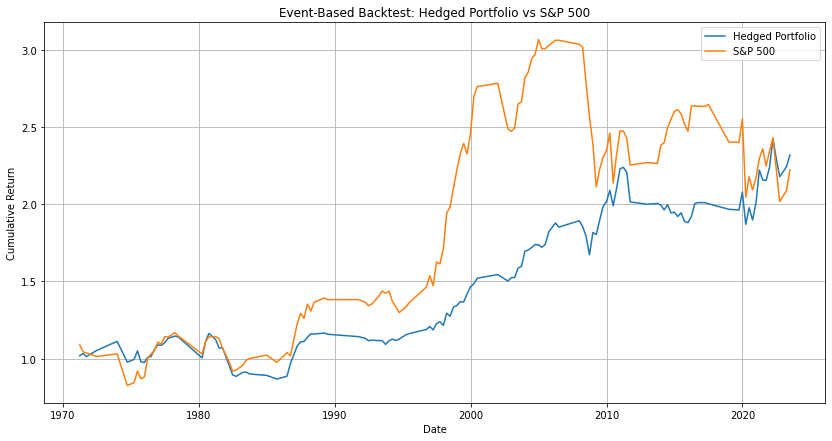

In [53]:
# Plot the backtest results
plt.figure(figsize=(14, 7))
plt.plot(backtest_results['Date'], backtest_results['Portfolio Value'], label='Hedged Portfolio')
plt.plot(combined_data['Date'], combined_data['S&P 500 Cumulative Return'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Event-Based Backtest: Hedged Portfolio vs S&P 500')
plt.legend()
plt.grid(True)
plt.show()

Visually, we can see that the hedged portfolio is much less volatile than the S&P 500. Eventually, the cumulative returns of both are approximately the same (if we hold the same strategy from Mar 1971 to Jun 2023), but we miss windows of opportunity to short the S&P 500 for profit (especially between 2000 and 2010).

One thing I would like to try is to optimise another conservative hedging strategy - minimizing MDD.

In [54]:
# Performance metrics
metrics = combined_data.groupby('Economic Regime').agg({
    'S&P 500 Return': ['mean', 'std'],
    'Gold Return': ['mean', 'std'],
    'US 10YR Bonds Return': ['mean', 'std']
}).reset_index()
metrics.columns = ['Economic Regime', 'S&P 500 Mean Return', 'S&P 500 Volatility',
                   'Gold Mean Return', 'Gold Volatility',
                   'US 10YR Bonds Mean Return', 'US 10YR Bonds Volatility']

In [55]:
# Function to calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    drawdowns = 1 - portfolio_values / np.maximum.accumulate(portfolio_values)
    max_drawdown = drawdowns.max()
    return max_drawdown

# Optimization function to minimize maximum drawdown
def max_drawdown_optimization(weights, returns):
    portfolio_returns = np.dot(returns, weights)
    portfolio_cumulative_returns = np.cumprod(1 + portfolio_returns)
    max_drawdown = calculate_max_drawdown(portfolio_cumulative_returns)
    return max_drawdown

def optimize_max_drawdown(returns):
    num_assets = returns.shape[1]
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(max_drawdown_optimization, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Optimize hedges to minimize maximum drawdown
drawdown_hedge_results = []

for regime in metrics['Economic Regime']:
    regime_data = combined_data[combined_data['Economic Regime'] == regime]
    returns = regime_data[['S&P 500 Return', 'Gold Return', 'US 10YR Bonds Return']].dropna().values
    result = optimize_max_drawdown(returns)
    drawdown_hedge_results.append({'Economic Regime': regime, 'Optimal Weights': result.x})


In [56]:
drawdown_hedge_results

[{'Economic Regime': 'High Inflation, High Growth',
  'Optimal Weights': array([0.65221901, 0.08341867, 0.26436232])},
 {'Economic Regime': 'High Inflation, Low Growth',
  'Optimal Weights': array([2.75424304e-01, 6.24145951e-17, 7.24575696e-01])},
 {'Economic Regime': 'Low Inflation, High Growth',
  'Optimal Weights': array([0.5598793 , 0.3992292 , 0.04089151])},
 {'Economic Regime': 'Low Inflation, Low Growth',
  'Optimal Weights': array([1.79651063e-01, 8.19888297e-01, 4.60640399e-04])}]

In [57]:
# Calculate cumulative returns
combined_data['S&P 500 Cumulative Return'] = (1 + combined_data['S&P 500 Return']).cumprod()
combined_data['Gold Cumulative Return'] = (1 + combined_data['Gold Return']).cumprod()
combined_data['US 10YR Bonds Cumulative Return'] = (1 + combined_data['US 10YR Bonds Return']).cumprod()

# Function to calculate hedged returns
def calculate_hedged_return(data, weights):
    return (weights[0] * data['S&P 500 Cumulative Return'] +
            weights[1] * data['Gold Cumulative Return'] +
            weights[2] * data['US 10YR Bonds Cumulative Return'])

# Event-based backtest with additional performance metrics
def event_based_backtest(data, hedge_results):
    portfolio_value = [1]
    current_regime = None
    daily_returns = []
    
    for index, row in data.iterrows():
        new_regime = row['Economic Regime']
        
        if new_regime != current_regime:
            current_regime = new_regime
            weights = next(result['Optimal Weights'] for result in hedge_results if result['Economic Regime'] == new_regime)
        
        period_return = (weights[0] * row['S&P 500 Return'] +
                         weights[1] * row['Gold Return'] +
                         weights[2] * row['US 10YR Bonds Return'])
        
        daily_returns.append(period_return)
        portfolio_value.append(portfolio_value[-1] * (1 + period_return))
    
    portfolio_value = portfolio_value[1:]
    daily_returns = np.array(daily_returns)
    
    # Calculate additional performance metrics
    sortino_ratio = calculate_sortino_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(np.array(portfolio_value))
    
    backtest_results = pd.DataFrame({
        'Date': data['Date'],  
        'Portfolio Value': portfolio_value
    })
    
    performance_metrics = {
        'Sortino Ratio': sortino_ratio,
        'Maximum Drawdown': max_drawdown
    }
    
    return backtest_results, performance_metrics

# Run the event-based backtest with the optimized weights to minimize drawdown
backtest_results, performance_metrics = event_based_backtest(combined_data, drawdown_hedge_results)

In [58]:
backtest_results.tail(10)

,Date,Portfolio Value
424,2020-12-31,3.829085
425,2021-03-31,6.403143
428,2021-06-30,6.346928
430,2021-09-30,6.362306
432,2021-12-31,6.636264
435,2022-03-31,7.292500
437,2022-06-30,7.437552
439,2022-09-30,8.319793
444,2023-03-31,7.704395
446,2023-06-30,8.123974


In [59]:
print("\nPerformance Metrics:\n", performance_metrics)


Performance Metrics:
 {'Sortino Ratio': -1.1850440190810632, 'Maximum Drawdown': 0.1772221810246014}


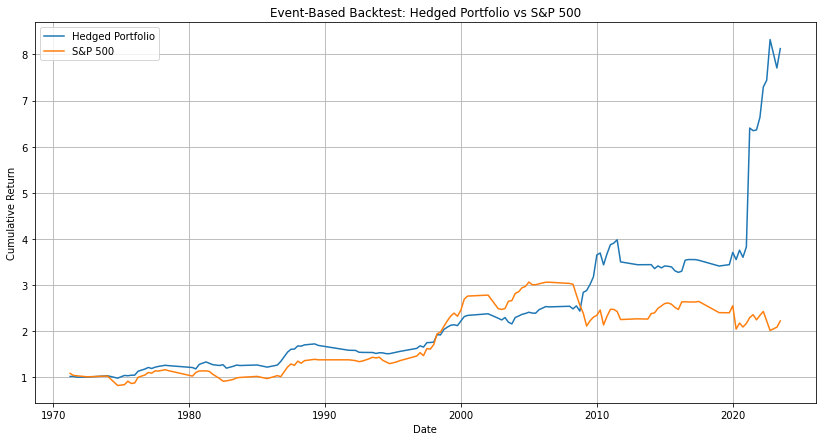

In [60]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(backtest_results['Date'], backtest_results['Portfolio Value'], label='Hedged Portfolio')
plt.plot(combined_data['Date'], combined_data['S&P 500 Cumulative Return'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Event-Based Backtest: Hedged Portfolio vs S&P 500')
plt.legend()
plt.grid(True)
plt.show()


Minimizing MDD seems to work very well, especially after 2020 when the cumulative returns rose sharply (might be COVID-19 related, but not too sure why). In fact, the hedged portfolio began to outperform the long S&P 500 position since 2008/09, which indicates that might be effective in tiding over possible financial crises. 

Of course, vectorised backtest like these have the benefit of hindsight and tend to overfit to past data. It is difficult to segregate economic regimes neatly into high/low inflation and growth over a long period of time using the same GDP and CPI thresholds. But this strategy has the benefit of being simple and low risk.